Prueba 1 terminada
Encontrados 8558 puntos clave.
Prueba 2 terminada
Encontrados 8457 puntos clave.


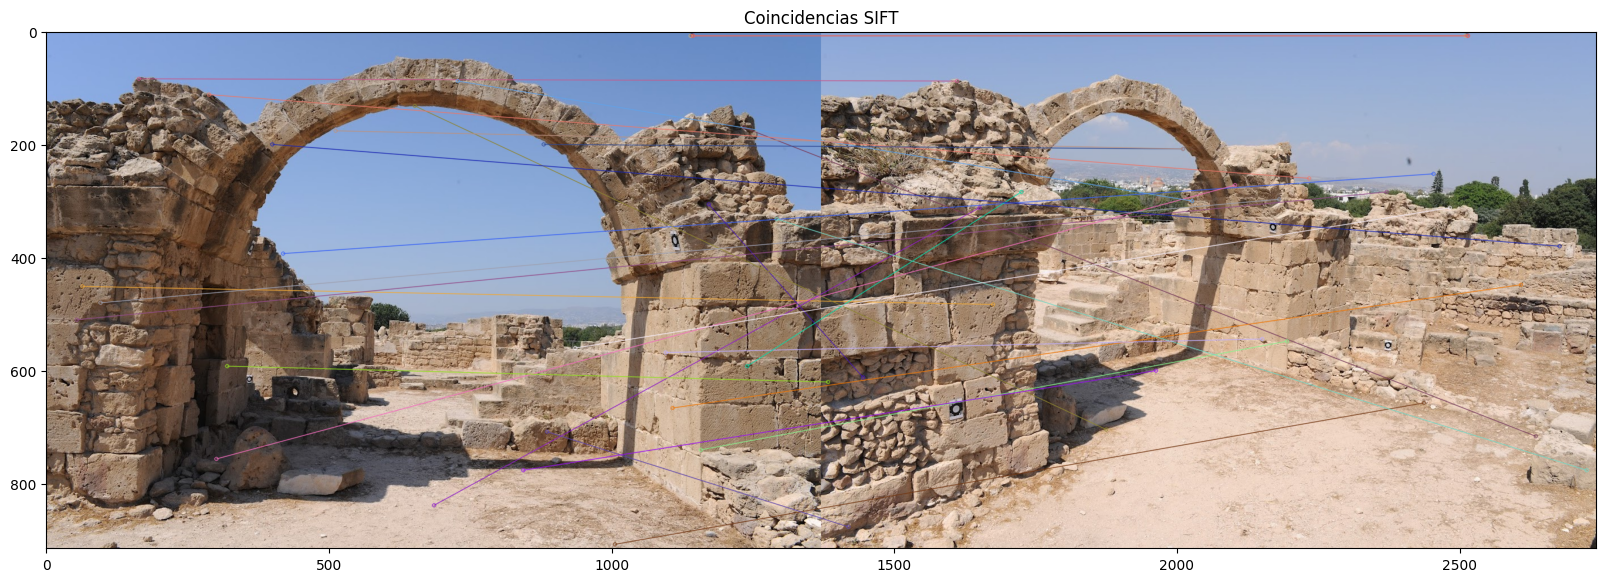

In [13]:
import numpy as np
from scipy.ndimage import convolve
import cv2
from matplotlib import pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

def generate_octave(init_level, escalas, sigma):
    octave = [init_level]
    k = 2 ** (1/escalas)
    # Generar el kernel gaussiano
    kernel = gaussian_filter(k * sigma)
    for _ in range(escalas):
        # Convolucionar el nivel anterior con el kernel gaussiano
        next_level = convolve(octave[-1], kernel, mode='nearest')
        octave.append(next_level)
    return octave

def generate_gaussian_pyramid(image, octaves, scales, sigma):
    pyramid = []
    for _ in range(octaves):
        octave = generate_octave(image, scales, sigma)
        pyramid.append(octave)
        # La siguiente imagen de la pirámide es la imagen de nivel 3 de la octava anterior
        image = octave[-3]
        # Reducir la resolución para la siguiente iteración
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid

def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = [octave[i] - octave[i+1] for i in range(len(octave) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid

def find_keypoints(dog_pyramid, max_corners=500, quality_level=0.06, min_distance=5):
    keypoints = []

    for octave_index, octave in enumerate(dog_pyramid):
        for scale_index, dog_level in enumerate(octave):
            # Convertir el nivel actual a uint8 (goodFeaturesToTrack requiere imágenes en escala de grises de 8 bits)
            dog_level_uint8 = cv2.normalize(dog_level, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Encontrar los puntos clave usando goodFeaturesToTrack
            corners = cv2.goodFeaturesToTrack(dog_level_uint8, maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance)

            if corners is not None:
                # Convertir las coordenadas a enteros y agregar a la lista de keypoints
                corners = corners.reshape(-1, 2)
                corners = corners * (2 ** octave_index)  # Escalar las coordenadas según la octava actual
                keypoints.extend([(int(x), int(y), scale_index + 1) for x, y in corners])

    return keypoints



def calculate_orientation(keypoint, image):
    x, y = np.int32(keypoint)
    size = 5  # You can adjust the size as needed
    region = np.int32(np.round(1.5 * size))

    # Ensure the region is within the image boundaries
    region = min(region, min(x, y, image.shape[0] - y - 1, image.shape[1] - x - 1))

    gradient_region = image[y - region:y + region + 1, x - region:x + region + 1]

    if gradient_region.size == 0:
        # If the region is empty, return a default orientation
        return 0.0

    gradients_x = cv2.Sobel(gradient_region, cv2.CV_64F, 1, 0, ksize=5)
    gradients_y = cv2.Sobel(gradient_region, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the orientation as the direction of the maximum gradient
    orientation = np.degrees(np.arctan2(np.sum(gradients_y), np.sum(gradients_x)))

    return orientation


def assign_orientation(keypoints, image):
    oriented_keypoints = []

    for keypoint in keypoints:
        x, y, scale_index = keypoint
        size = 2 ** (scale_index - 1)

        # Calculate the orientation for the keypoint
        orientation = calculate_orientation((x, y), image)

        # Add the keypoint with orientation to the list
        oriented_keypoints.append((x, y, size, orientation))

    return oriented_keypoints

def sift(img, octaves, scales, sigma):
    img = np.array(img)
    img = rgb2gray(img)
    gaussian_pyramid = generate_gaussian_pyramid(img, octaves, scales, sigma)
    dog_pyramid = generate_dog_pyramid(gaussian_pyramid)
    keypoints = find_keypoints(dog_pyramid)
    
    oriented_keypoints = assign_orientation(keypoints, img)
    
    sift = cv2.SIFT_create()
    keypoints_for_sift = [cv2.KeyPoint(float(x), float(y), float(scale), float(orientation)) for x, y, scale, orientation in oriented_keypoints]
    _, descriptors = sift.compute(img, keypoints_for_sift)
    return keypoints, descriptors

imagen1 = cv2.imread('prueba4.jpg')
imagen2 = cv2.imread('prueba6.jpg')
escalas = 5  
sigma = 1.6
octavas = 4 

keypoints1, descriptores1 = sift(imagen1, octavas, escalas, sigma)
print("Prueba 1 terminada")
print(f'Encontrados {len(keypoints1)} puntos clave.')
keypoints2, descriptores2 = sift(imagen2, octavas, escalas, sigma)
print("Prueba 2 terminada")
print(f'Encontrados {len(keypoints2)} puntos clave.')

# Crear un objeto de coincidencia de fuerza bruta
bf = cv2.BFMatcher()

# Realizar la coincidencia de descriptores
coincidencias = bf.knnMatch(descriptores1, descriptores2, k=2)

# Aplicar el filtro de Ratio Test
buenas_coincidencias = []
for m, n in coincidencias:
    if m.distance < 0.65 * n.distance:
        buenas_coincidencias.append(m)

# Convert keypoints to list of cv2.KeyPoint objects
keypoints1_list = [cv2.KeyPoint(float(x), float(y), float(scale)) for x, y, scale in keypoints1]
keypoints2_list = [cv2.KeyPoint(float(x), float(y), float(scale)) for x, y, scale in keypoints2]

resultado = cv2.drawMatches(imagen1, keypoints1_list, imagen2, keypoints2_list, buenas_coincidencias, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('Coincidencias SIFT', resultado)
cv2.waitKey(0)
cv2.destroyAllWindows()

imagen1_rgb = cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(imagen1_rgb)
plt.title('Coincidencias SIFT')
plt.show()
